## Overview

This notebook illustrates the basic functionality, structure, and utility of neural networks using Python / NumPy.   It deliberately avoids using any of the widely-used libraries for neural networks solely for illustrative purposes.

Our example dataset here is the famous `iris` dataset.  Four plant dimensions (sepal lengths and widths; petal lengths and widths) were recorded for 150 plants of three different species.  The goal will be to compare several methods of "predicting" the species of the plant from the data.  Thus, this problem aims to predict a categorical output from multidimensional, continuous data.

The examples here show that simple NNs can recapitulate the results of k-means clustering.

In [1]:
from collections import Counter

# algorithms
import numpy as np
from sklearn import datasets, cluster

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


# for reproducibility
np.random.seed(0)

## Clustering a famous dataset

The goal here will be to cluster a famous, simple dataset using k-means, and then train a neural network to replicate the clustering results.

In [2]:
iris = datasets.load_iris()
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(iris.data) 

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

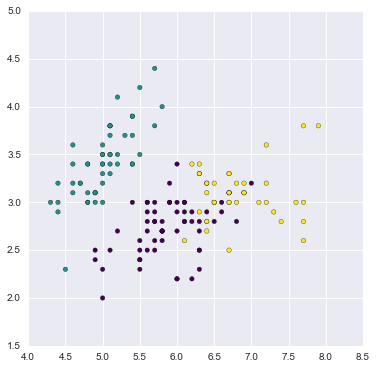

In [3]:
plt.figure(figsize = [6, 6])
plt.scatter(iris.data[:, 0], iris.data[:, 1], c=k_means.labels_.astype(float), cmap=cm.viridis)

K-means with the parameters we have chosen perfoms reasonably well at clustering the data.  

In [4]:
Counter(zip(iris.target, k_means.labels_))

Counter({(0, 1): 50, (1, 0): 48, (1, 2): 2, (2, 0): 14, (2, 2): 36})

The summary above shows that the "correct" mapping between k-means labels and original data labels is:

* iris `0` &rarr; k-means `1`
* iris `1` &rarr; k-means `0`
* iris `2` &rarr; k-means `2`

The k-means clustering was:
* correct on all 50 iris plants of (iris) species `0`
* correct on 48 / 50 plants of iris species `1`, while 2 of 50 type-`1` plants were misclassified as k-means class `2`
* correct on 36 / 50 plants of iris species `2`, while 14 type-`2` plants were misclassified as k-means class `0`

## Replicating the clustering using a NN

### Creating a training set

In [5]:
# create test & training data
data_points = len(k_means.labels_)

## would be better to sample equally from each cluster when partitioning data to training and test
test_pts = np.random.choice(xrange(data_points), 
                            size=int(0.5 * data_points),
                            replace = False)
training_pts = np.asarray([i for i in xrange(data_points) if i not in test_pts])

# the training data is input to the NN
X = iris.data[training_pts, :]
y = np.array([k_means.labels_[training_pts]]).T 

# convert y to "wide" format with 1 bool column per class
from scipy.sparse import coo_matrix

data = np.ones(len(y), dtype = 'bool')
y_base = y.reshape(-1)
y_wide = coo_matrix((data, (xrange(len(y)), y_base)), shape = (len(y), max(y) + 1), dtype=float).toarray()

### Some function definitions

In [6]:
# sigmoid function
def sigmoid(x, deriv=False):
    """Numerical evaluation of the sigmoid function or its derivative."""
    if(deriv == True):
        return x - x*x
    return 1/(1+np.exp(-x)) 

def initialize_weights(shape):
    """Initialize weights randomly with mean 0."""
    return 2*np.random.random(shape) - 1

def set_level(prev_level, weights):
    """Sets the levels of a layer in a NN using levels of the previous layer & weights of current layer."""
    return sigmoid(prev_level.dot(weights))

def propagate_error(higher_level_delta, this_level, weights, y = None, highest_level = False):
    """
    """
    if highest_level:
        this_level_error = y - this_level
    else:        
        this_level_error = higher_level_delta.dot(weights.T)
    return this_level_error * sigmoid(this_level, deriv=True)

### Defining and training the NN

In [7]:
# the dimensions of the NN
num_points = len(y_wide)
num_cols = X.shape[1]
num_neurons = 10  ## in this network all internal layers are the same size
num_outputs = y_wide.shape[1]

weight_shapes = [(num_cols, num_neurons),
                 (num_neurons, num_neurons),
                 (num_neurons, num_neurons),
                 (num_neurons, num_outputs)
                 ]

layer_shapes = [(num_points, num_cols),
                (num_points, num_neurons),
                (num_points, num_neurons),
                (num_points, num_neurons),
                (num_points, num_outputs)
                ]

# initialize weights and layers
weights = [initialize_weights(shape) for shape in weight_shapes]
layer = [np.zeros(shape) for shape in layer_shapes]
delta = [np.zeros(shape) for shape in layer_shapes]

# train the NN
for iter in xrange(400):
    # scale input to be in -1, 1
    layer[0] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * 2 - 1
    
    # forward propagation
    for idx in xrange(1, 5):
        layer[idx] = set_level(layer[idx-1], weights[idx-1])
        
    # backpropagation of error
    delta[4] = propagate_error(None, layer[4], None, y_wide, highest_level = True)
    
    for idx in xrange(3, -1, -1):
        delta[idx] = propagate_error(delta[idx+1], layer[idx], weights[idx])
        weights[idx] += layer[idx].T.dot(delta[idx+1])

### Plotting the results of training

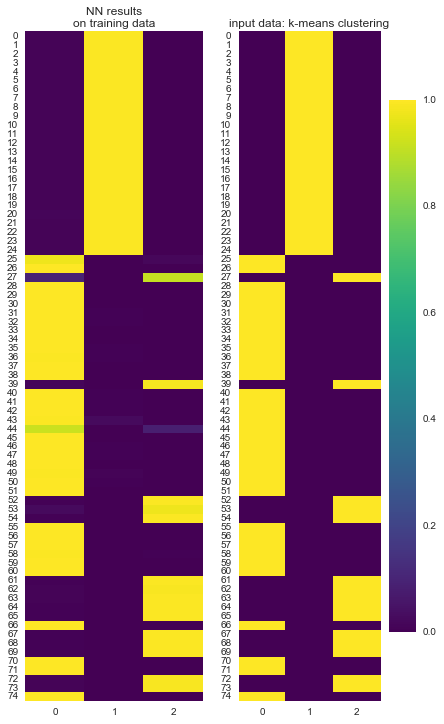

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = [7, 12])
sns.heatmap(layer[4], cmap = cm.viridis, ax = ax1, cbar = False)
sns.heatmap(y_wide, cmap = cm.viridis, ax = ax2)
ax1.set_title('NN results\non training data')
ax2.set_title('input data: k-means clustering')

### Calculating the results on the test data

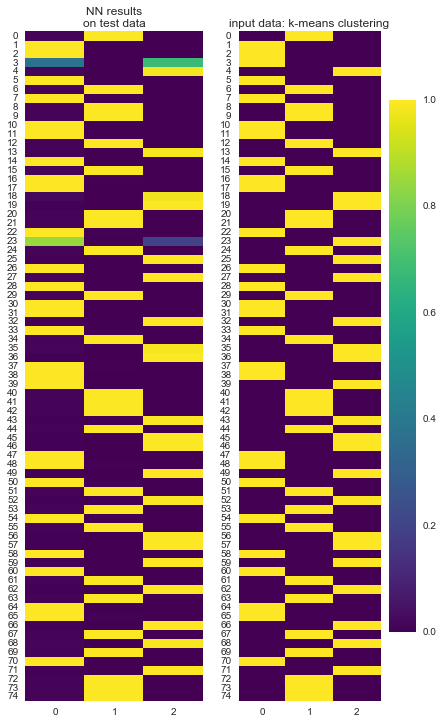

In [9]:
X = iris.data[test_pts, :]
y = np.array([k_means.labels_[test_pts]]).T 

# convert y to "wide" format with 1 bool column per class
from scipy.sparse import coo_matrix
data = np.ones(len(y), dtype = 'bool')
y_base = y.reshape(-1)
y_wide = coo_matrix((data, (xrange(len(y)), y_base)), shape = (len(y), max(y) + 1), dtype=float).toarray()

# scale input to be in -1, 1
layer[0] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * 2 - 1

# forward propagation
for idx in xrange(1, 5):
    layer[idx] = set_level(layer[idx-1], weights[idx-1])

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize = [7, 12])
sns.heatmap(layer[4], cmap = cm.viridis, ax = ax1, cbar = False)
sns.heatmap(y_wide, cmap = cm.viridis, ax = ax2)
ax1.set_title('NN results\non test data')
ax2.set_title('input data: k-means clustering')

This example shows that NNs can recapitulate the results of k-means clustering very well!  The next logical question is whether NNs can do better than our (naive, unoptimized) k-means clustering result.  Let's train the NN using ground-truth data rather than k-means results.

In [10]:
# create test & training data
data_points = len(iris.target)

## would be better to sample equally from each cluster when partitioning data to training and test
test_pts = np.random.choice(xrange(data_points), 
                            size=int(0.5 * data_points),
                            replace = False)
training_pts = np.asarray([i for i in xrange(data_points) if i not in test_pts])

# the training data is input to the NN
X = iris.data[training_pts, :]
y = np.array([iris.target[training_pts]]).T 

# convert y to "wide" format with 1 bool column per class
from scipy.sparse import coo_matrix

data = np.ones(len(y), dtype = 'bool')
y_base = y.reshape(-1)
y_wide = coo_matrix((data, (xrange(len(y)), y_base)), shape = (len(y), max(y) + 1), dtype=float).toarray()

# the dimensions of the NN
num_points = len(y_wide)
num_cols = X.shape[1]
num_neurons = 10  ## in this network all internal layers are the same size
num_outputs = y_wide.shape[1]

weight_shapes = [(num_cols, num_neurons),
                 (num_neurons, num_neurons),
                 (num_neurons, num_neurons),
                 (num_neurons, num_outputs)
                 ]

layer_shapes = [(num_points, num_cols),
                (num_points, num_neurons),
                (num_points, num_neurons),
                (num_points, num_neurons),
                (num_points, num_outputs)
                ]

# initialize weights and layers
weights = [initialize_weights(shape) for shape in weight_shapes]
layer = [np.zeros(shape) for shape in layer_shapes]
delta = [np.zeros(shape) for shape in layer_shapes]

# train the NN
for iter in xrange(400):
    # scale input to be in -1, 1
    layer[0] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * 2 - 1
    
    # forward propagation
    for idx in xrange(1, 5):
        layer[idx] = set_level(layer[idx-1], weights[idx-1])
        
    # backpropagation of error
    delta[4] = propagate_error(None, layer[4], None, y_wide, highest_level = True)
    
    for idx in xrange(3, -1, -1):
        delta[idx] = propagate_error(delta[idx+1], layer[idx], weights[idx])
        weights[idx] += layer[idx].T.dot(delta[idx+1])

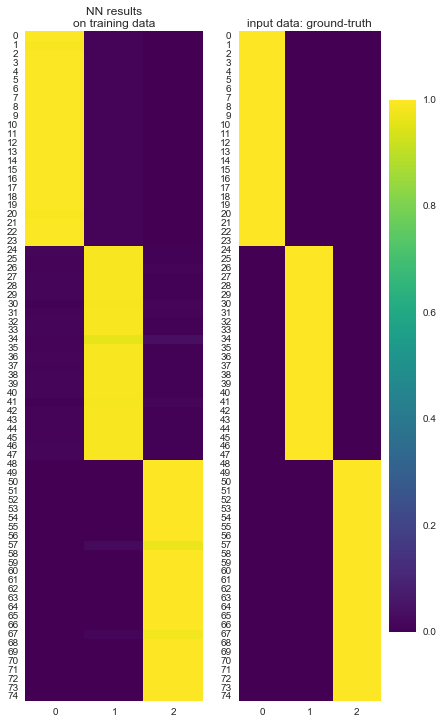

In [11]:
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize = [7, 12])
sns.heatmap(layer[4], cmap = cm.viridis, ax = ax1, cbar = False)
sns.heatmap(y_wide, cmap = cm.viridis, ax = ax2)
ax1.set_title('NN results\non training data')
ax2.set_title('input data: ground-truth')

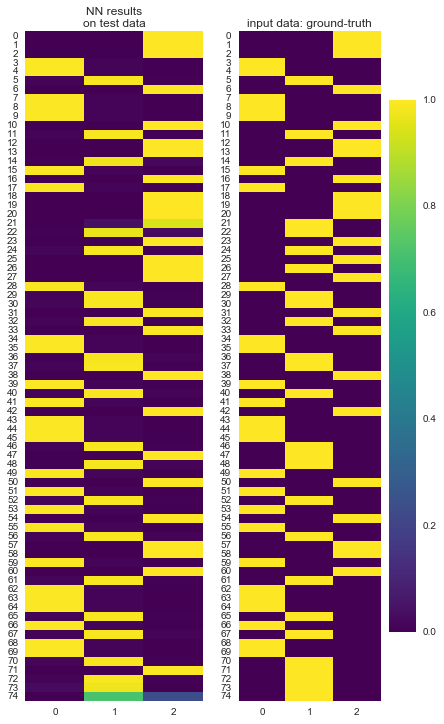

In [12]:
X = iris.data[test_pts, :]
y = np.array([iris.target[test_pts]]).T 

# convert y to "wide" format with 1 bool column per class
from scipy.sparse import coo_matrix
data = np.ones(len(y), dtype = 'bool')
y_base = y.reshape(-1)
y_wide = coo_matrix((data, (xrange(len(y)), y_base)), shape = (len(y), max(y) + 1), dtype=float).toarray()

# scale input to be in -1, 1
layer[0] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) * 2 - 1

# forward propagation
for idx in xrange(1, 5):
    layer[idx] = set_level(layer[idx-1], weights[idx-1])

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize = [7, 12])
sns.heatmap(layer[4], cmap = cm.viridis, ax = ax1, cbar = False)
sns.heatmap(y_wide, cmap = cm.viridis, ax = ax2)
ax1.set_title('NN results\non test data')
ax2.set_title('input data: ground-truth')

NNs outperformed k-means, at least in this simple case.